# Explorative Data Analysis

In this notebook you find the explorative data anaylsis for the label data of patients.
There is also diagnostic data of the patients, data of the used MRI machines and for some cases (like external admissions) there ist lab data available.


## Imports and Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')


In [2]:
# runs the clean and preprocessing notebook
%run "clean_preprocessing.ipynb"

Start Clean and Preprocessing
End Clean and Preprocessing


In [3]:
# runs the data_partitioning notebook
%run "data_partitioning.ipynb"

Start Data Partitioning
Total Dataframe Train rows: 127
Total Dataframe Test rows: 32
Label Distribution relative Difference between Train- and Testset:
 ± 1.649 %
End Data Partitioning


In [4]:
# read train data set
df = pd.read_csv(r'../data/train_data.csv')

In [5]:
#TODO: use only single patients for eda
df_patients = df[df['Patient_ID'].duplicated()]
df_patients

,Patient_ID,Date_MRI,ID_MRI_Machine,Adenoma_size,Label_Quality,Entry_date,Operation_date,Diagnosis,Patient_age,Prolactin,...,Post_OP_hormone_cortico,Post_OP_hormone_gonado,Post_OP_hormone_keine,Post_OP_hormone_somato,Post_OP_hormone_thyreo,Post_OP_hormone_ADH,Post_OP_hormone_hyperprolaktin,Post_OP_hormone_intakt,Category,Case_ID
1,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,41161508
2,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,41161508
3,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,40370667
4,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,40370667
5,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,40325978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,300087536,2021-10-14 12:23:00,MRI1,mikro,NaN,2020-04-27,NaN,rathke,63,NaN,...,0,0,1,0,0,0,0,0,non-prolaktinom,41018041
396,300087536,2021-10-14 12:23:00,MRI1,mikro,NaN,2020-04-27,NaN,rathke,63,NaN,...,0,0,1,0,0,0,0,0,non-prolaktinom,40727899
398,66706,2022-12-12 11:42:00,MRI3,makro,NaN,2020-10-01,NaN,prolaktinom,62,NaN,...,0,0,1,0,0,0,0,0,prolaktinom,41364667
399,66706,2022-12-12 11:42:00,MRI3,makro,NaN,2020-10-01,NaN,prolaktinom,62,NaN,...,0,0,1,0,0,0,0,0,prolaktinom,41095067


In [6]:
# make datetime values
df["Date_MRI"] = pd.to_datetime(df["Date_MRI"])
df["Entry_date"] = pd.to_datetime(df["Entry_date"])
df["Operation_date"] = pd.to_datetime(df["Operation_date"])
# set category data type in pandas, check datatypes
df['ID_MRI_Machine'] = df['ID_MRI_Machine'].astype('category')
df['Adenoma_size'] = df['Adenoma_size'].astype('category')
df['Label_Quality'] = df['Label_Quality'].astype('category')
df['Diagnosis'] = df['Diagnosis'].astype('category')
df['Category'] = df['Category'].astype('category')

## Dataframe Summary

In [7]:
df.head()

,Patient_ID,Date_MRI,ID_MRI_Machine,Adenoma_size,Label_Quality,Entry_date,Operation_date,Diagnosis,Patient_age,Prolactin,...,Post_OP_hormone_cortico,Post_OP_hormone_gonado,Post_OP_hormone_keine,Post_OP_hormone_somato,Post_OP_hormone_thyreo,Post_OP_hormone_ADH,Post_OP_hormone_hyperprolaktin,Post_OP_hormone_intakt,Category,Case_ID
0,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,41301678
1,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,41161508
2,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,41161508
3,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,40370667
4,300072545,2022-08-13 09:57:00,MRI1,makro,NaN,2017-07-01,2017-07-28,inaktiv (gonado),57,NaN,...,0,1,0,0,0,0,0,0,non-prolaktinom,40370667


In [8]:
df.tail()

,Patient_ID,Date_MRI,ID_MRI_Machine,Adenoma_size,Label_Quality,Entry_date,Operation_date,Diagnosis,Patient_age,Prolactin,...,Post_OP_hormone_cortico,Post_OP_hormone_gonado,Post_OP_hormone_keine,Post_OP_hormone_somato,Post_OP_hormone_thyreo,Post_OP_hormone_ADH,Post_OP_hormone_hyperprolaktin,Post_OP_hormone_intakt,Category,Case_ID
396,300087536,2021-10-14 12:23:00,MRI1,mikro,NaN,2020-04-27,NaT,rathke,63,NaN,...,0,0,1,0,0,0,0,0,non-prolaktinom,40727899
397,66706,2022-12-12 11:42:00,MRI3,makro,NaN,2020-10-01,NaT,prolaktinom,62,NaN,...,0,0,1,0,0,0,0,0,prolaktinom,41730697
398,66706,2022-12-12 11:42:00,MRI3,makro,NaN,2020-10-01,NaT,prolaktinom,62,NaN,...,0,0,1,0,0,0,0,0,prolaktinom,41364667
399,66706,2022-12-12 11:42:00,MRI3,makro,NaN,2020-10-01,NaT,prolaktinom,62,NaN,...,0,0,1,0,0,0,0,0,prolaktinom,41095067
400,66706,2022-12-12 11:42:00,MRI3,makro,NaN,2020-10-01,NaT,prolaktinom,62,NaN,...,0,0,1,0,0,0,0,0,prolaktinom,41044665


In [9]:
print("Total Dataframe rows:", len(df))
print("Total Dataframe columns:", len(df.columns))

Total Dataframe rows: 401
Total Dataframe columns: 29


## Distribution Analysis
we will take a look at the distributions of the variables and check for outliers as well.

### Data of MRI
First we will take a look at the distribution of the data for the MRI which were done. 

In [10]:
column = 'Date_MRI'
print("Range of MRI date:", df[column].min().strftime('%d.%m.%Y'), "to", df[column].max().strftime('%d.%m.%Y'))
print("Missing values:", sum(df[column].isna()))

Range of MRI date: 04.10.2021 to 11.05.2023
Missing values: 0


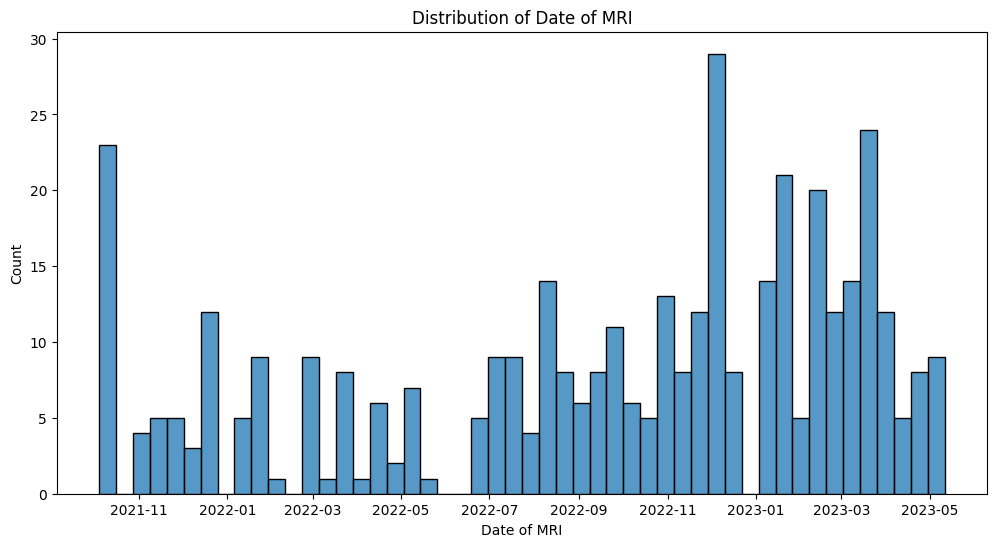

In [11]:
sns.histplot(df[column],bins=50)
plt.title(f"Distribution of Date of MRI")
plt.xlabel('Date of MRI')
plt.show()

### Data of MRI Machines

We will analyse the distribution of the used MRI Machines. As they are setup the same they will not have a big influence in the classification.


In [12]:
column= 'ID_MRI_Machine'
print("Unique MRI Machines:", df[column].unique())
print("Missing values:", sum(df[column].isna()))

Unique MRI Machines: ['MRI1', 'MRI3', 'MRI4', 'MRI2', 'MRSZ']
Categories (5, object): ['MRI1', 'MRI2', 'MRI3', 'MRI4', 'MRSZ']
Missing values: 0


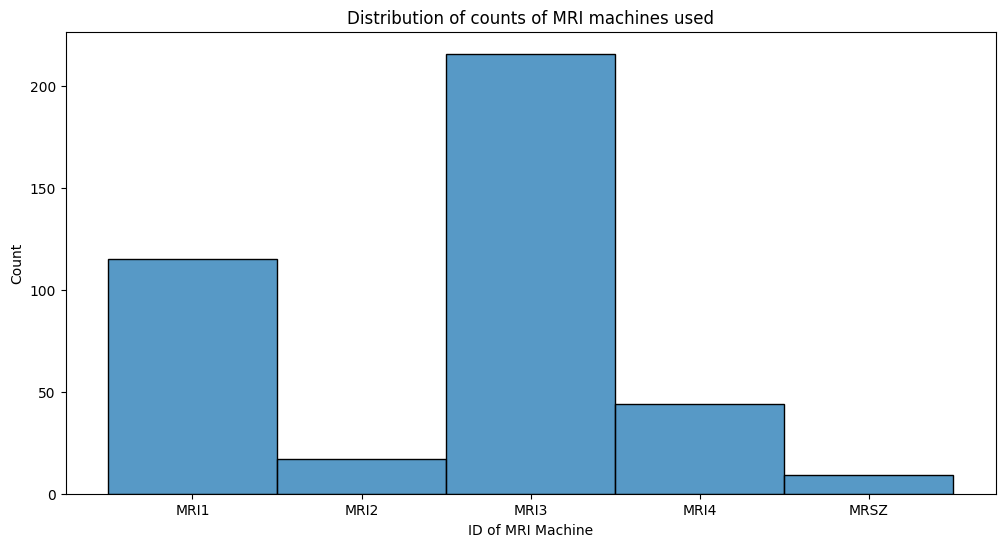

In [13]:
sns.histplot(df[column])
plt.title(f"Distribution of counts of MRI machines used")
plt.xlabel('ID of MRI Machine')
plt.show()

### Data Features (screening data)

#### Adenoma Size
The column for the 'Adenoma_size' describes if an Adenoma was labeled as micro or macro.
Micro is defined as <10mm and a macro is defined as >= 10 mm in size.

In [14]:
column= 'Adenoma_size'
print("Summary Statistics:\n",df[column].describe())
print("Percentage Distribution:\n",df[column].value_counts(normalize=True) * 100)
print("Missing values Adenoma size:", sum(df[column].isna()))

Summary Statistics:
 count       396
unique        2
top       makro
freq        279
Name: Adenoma_size, dtype: object
Percentage Distribution:
 Adenoma_size
makro    70.454545
mikro    29.545455
Name: proportion, dtype: float64
Missing values Adenoma size: 5


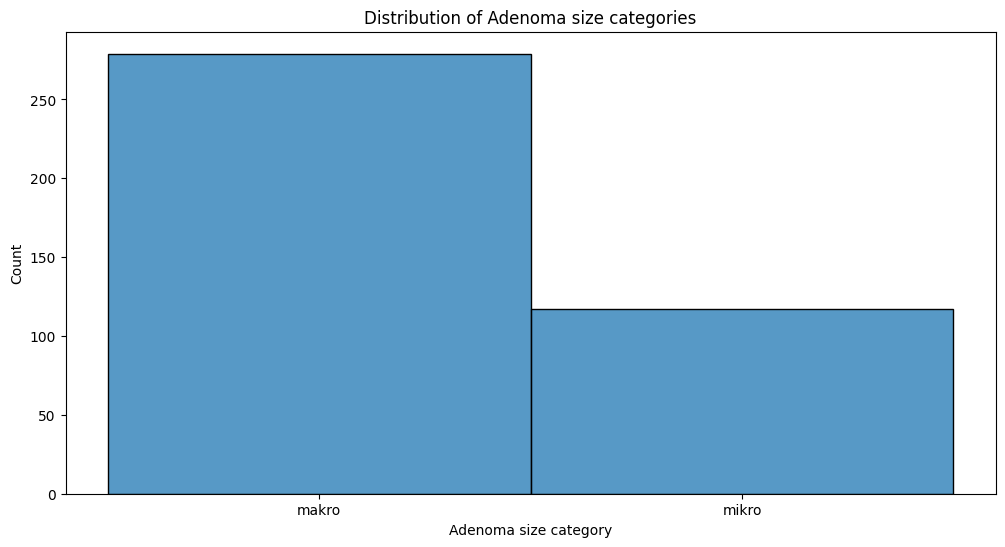

In [15]:
sns.histplot(df[column])
plt.title(f"Distribution of Adenoma size categories")
plt.xlabel('Adenoma size category')
plt.show()

#### Pre Operation hormonal disfunctions
The column for the 'Ausfälle prä' describes if a patient was experiencing an under- or an overproduction of a type of hormone (produced by the pituitary gland) before an operation.
Values which indicate a prolaktinoma are an overproduction of prolactin (hyperprolaktin).


In [16]:
# define all "pre op" columns
pre_op_columns = [col for col in df.columns if "Pre_" in col]

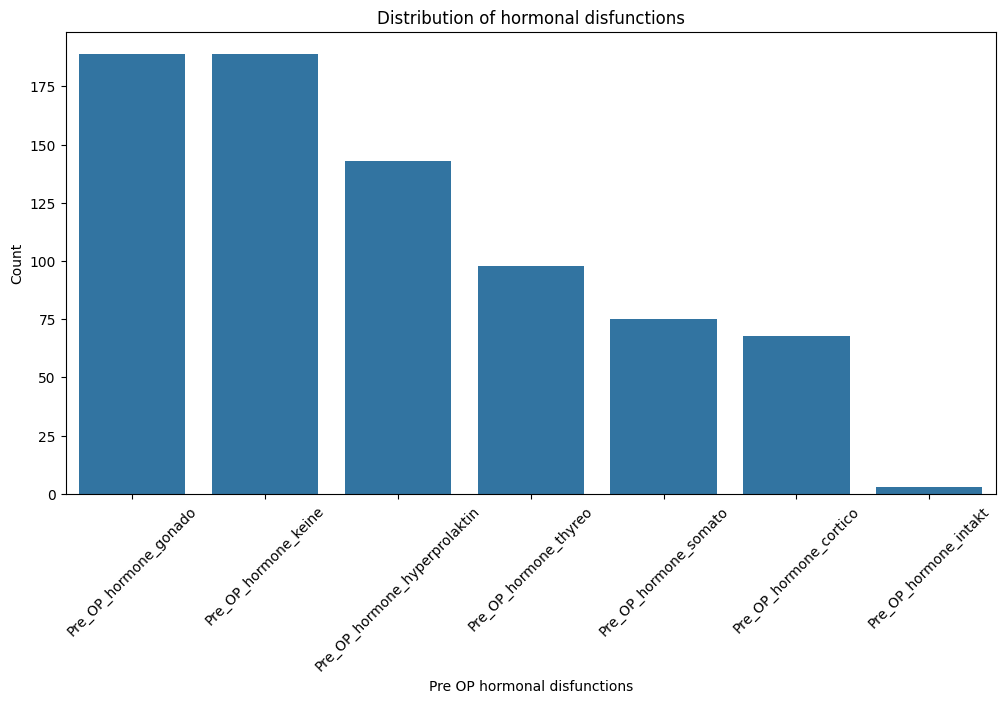

In [17]:
# summarise and sort the pre op column values
summary=df[pre_op_columns].sum().sort_values(ascending=False)
sns.barplot(x=summary.index, y=summary.values)
plt.title("Distribution of hormonal disfunctions")
plt.xlabel("Pre OP hormonal disfunctions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

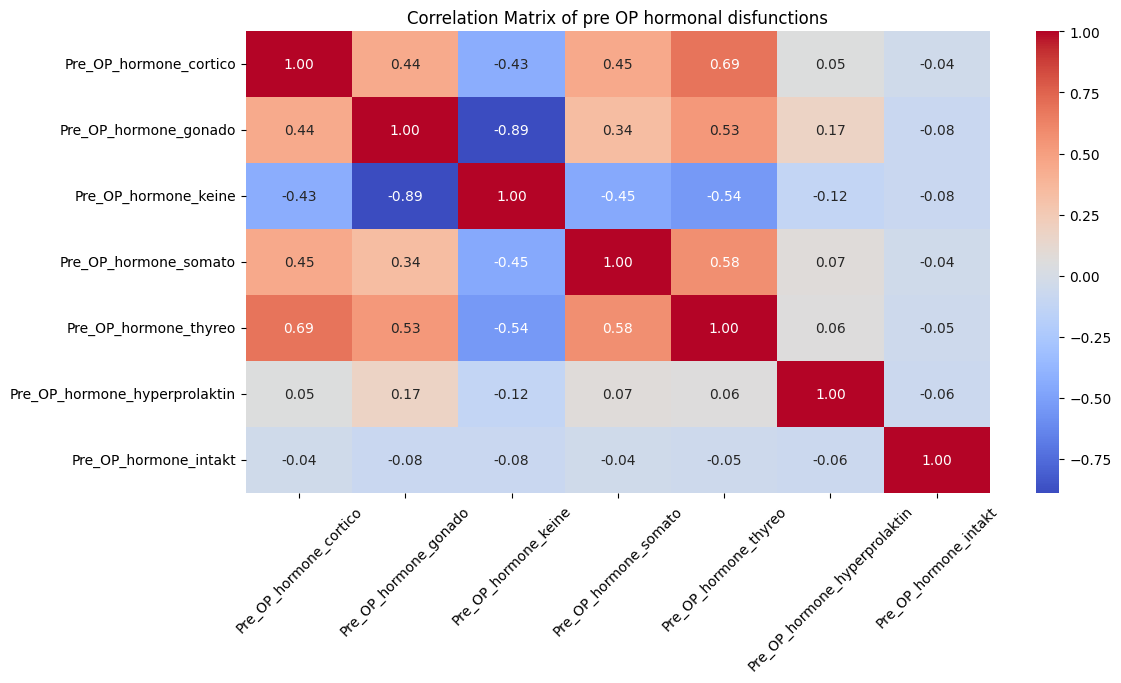

In [18]:
# correlate all pre op columns to each other
correlation_matrix = df[pre_op_columns].corr()
# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of pre OP hormonal disfunctions")
plt.xticks(rotation=45)
plt.show()

#### Post Operation hormonal disfunctions
The column for the 'Ausfälle post' describes if a patient was experiencing an under- or an overproduction of a type of hormone (produced by the pituitary gland) after an operation.
These are mostly used to confirm a successful operation.

In [19]:
# define all "post op" columns
post_op_columns = [col for col in df.columns if "Post_" in col]

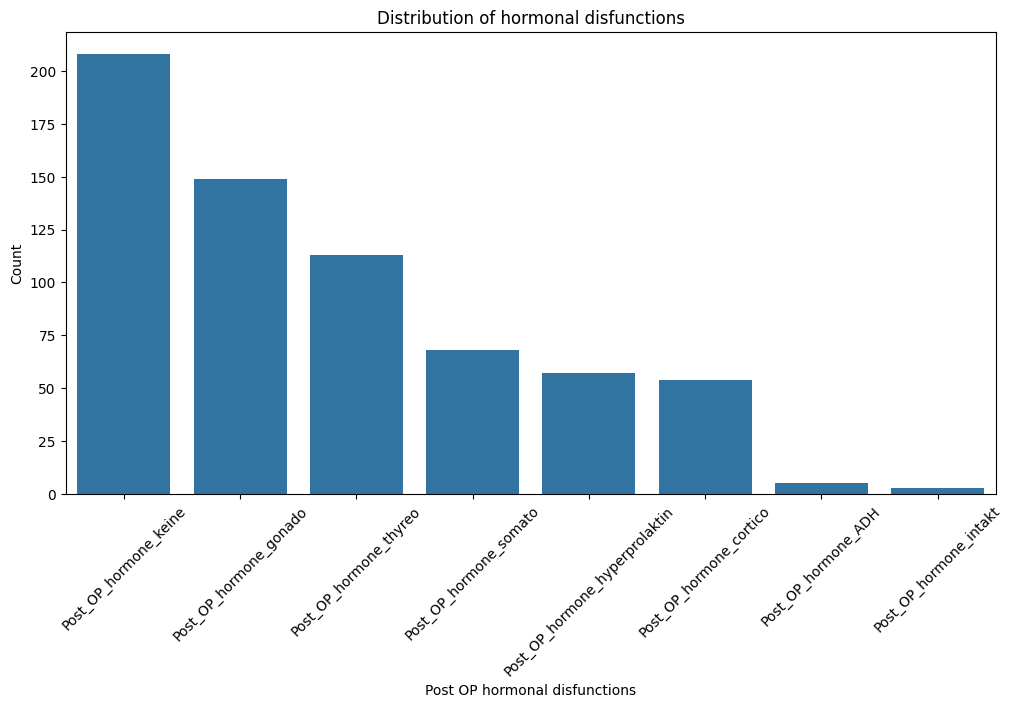

In [20]:
# summarise and sort the post op column values
summary=df[post_op_columns].sum().sort_values(ascending=False)
sns.barplot(x=summary.index, y=summary.values)
plt.title("Distribution of hormonal disfunctions")
plt.xlabel("Post OP hormonal disfunctions")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()

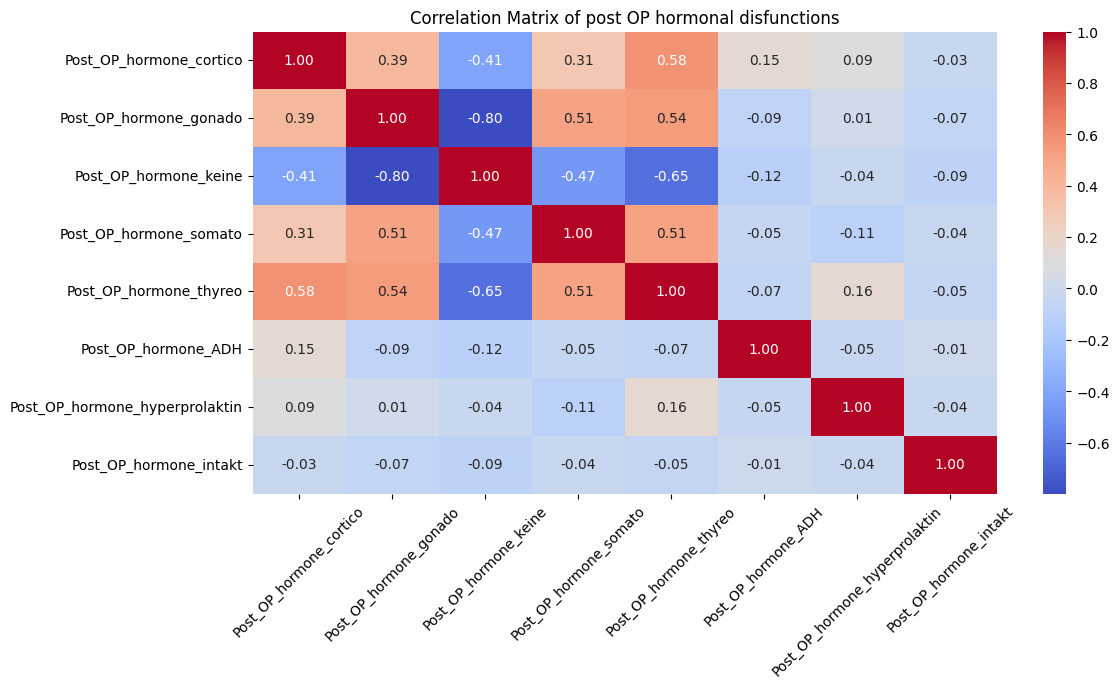

In [21]:
# correlate all pre op columns to each other
correlation_matrix = df[post_op_columns].corr()
# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of post OP hormonal disfunctions")
plt.xticks(rotation=45)
plt.show()

#### Pre and Post Operation hormonal disfunctions
We also take a look at the correlations of pre and post operational hormonal disfunctions.

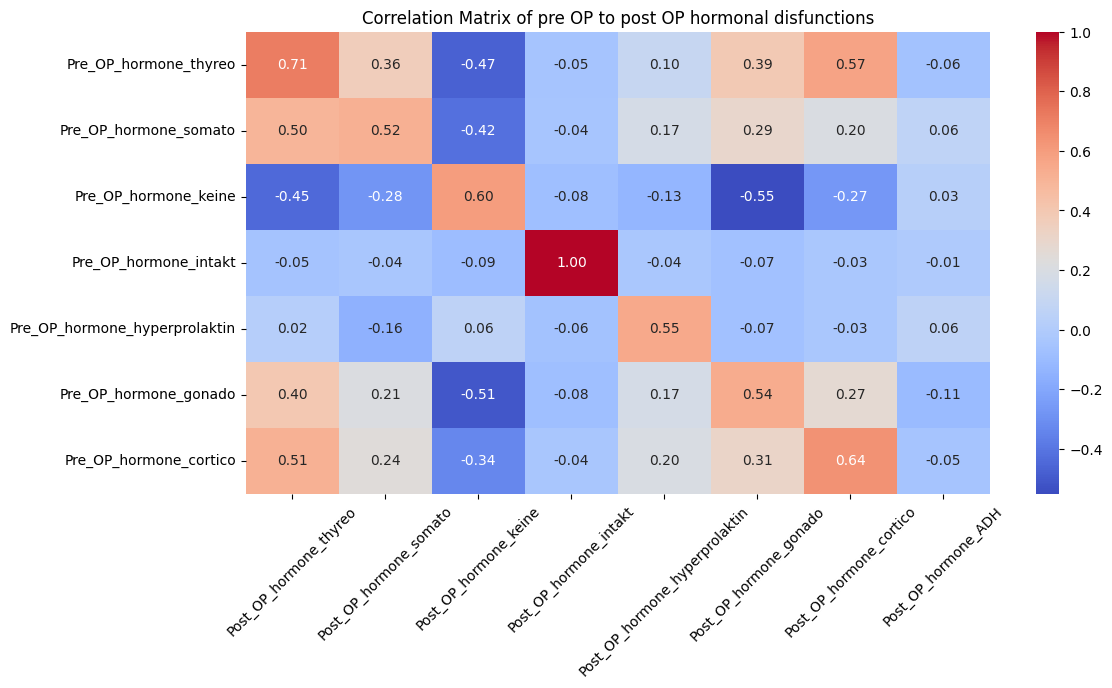

In [22]:
# correlate all pre and post columns against each other, and sort the values alphabetically by row and then by column
correlation_matrix = df[pre_op_columns+post_op_columns].corr()
correlation_matrix= correlation_matrix.sort_index(ascending=False).sort_index(axis=1, ascending=False)
# Create a heatmap using Seaborn, only use the pre columns on the y-axis and the post columns on the x-axis
sns.heatmap(correlation_matrix.iloc[0:7, 7:], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of pre OP to post OP hormonal disfunctions")
plt.xticks(rotation=45)
plt.show()

#### Data Label Quality
In the label data there is column with comments to the quality of the data used for the labeling. This includes if a decision to label was complicated, the decision is not confident or other data quality issues were found.



In [23]:
column= 'Label_Quality'
print("Summary Statistics Data Quality:\n", df[column].describe())
print("Missing values:", sum(df[column].isna()))

Summary Statistics Data Quality:
 count         20
unique         9
top       extern
freq           8
Name: Label_Quality, dtype: object
Missing values: 381


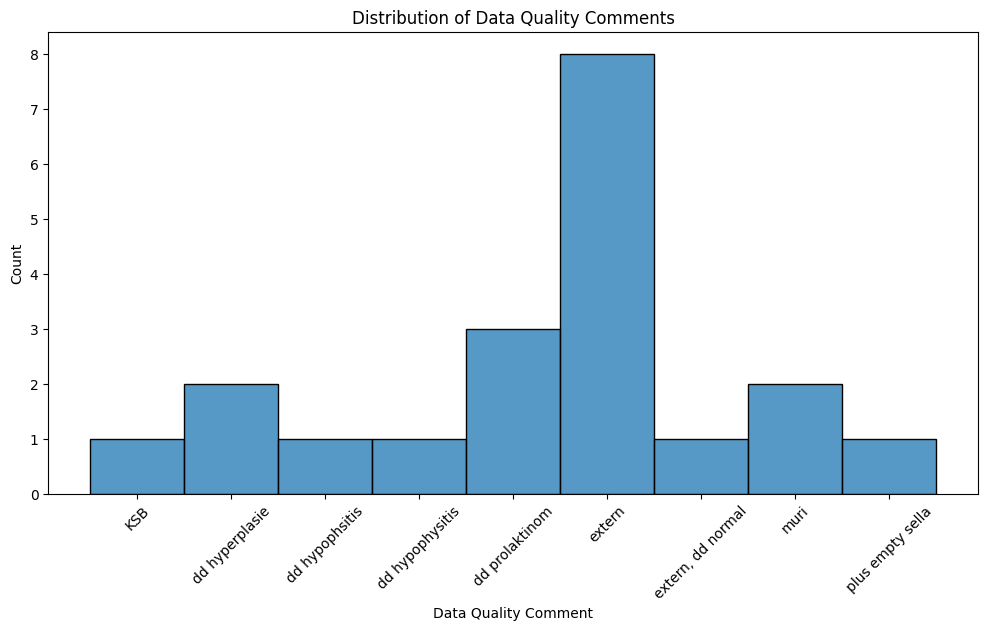

In [24]:
sns.histplot(df[column])
plt.title(f"Distribution of Data Quality Comments")
plt.xticks(rotation=45)
plt.xlabel('Data Quality Comment')
plt.show()

#### Date of Entry and Operation
The columns for the 'Eintrittsdatum' and 'Operationdatum' describe when a patient entered the hospital and also when the operation took place.
The difference between these values can show the significance or the extraordinary need for an operation.

In [25]:
column = 'Entry_date'
print("Range of Entry date:", df[column].min().strftime('%d.%m.%Y'), "to", df[column].max().strftime('%d.%m.%Y'))
print("Missing values:", sum(df[column].isna()))

Range of Entry date: 01.01.1999 to 12.10.2023
Missing values: 5


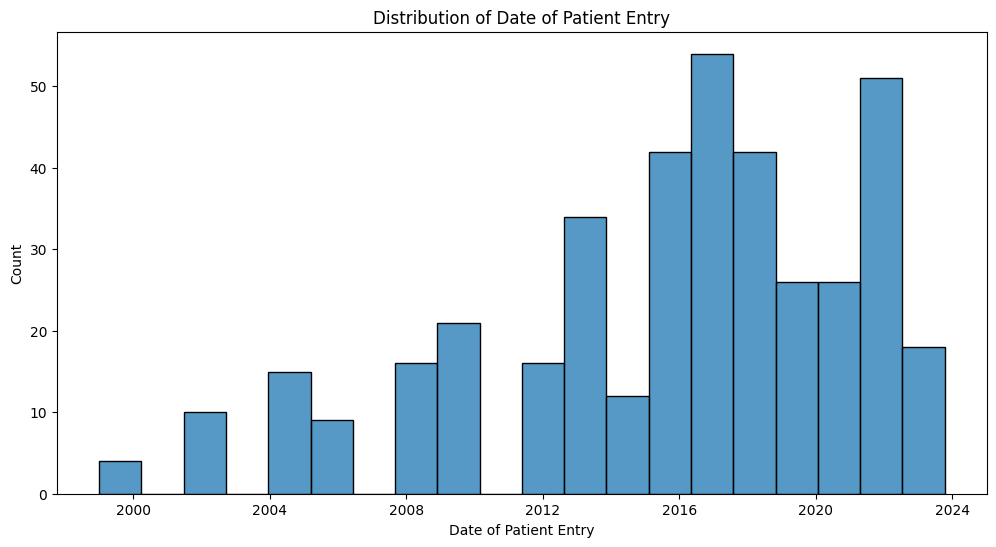

In [26]:
sns.histplot(df[column],bins=20)
plt.title(f"Distribution of Date of Patient Entry")
plt.xlabel('Date of Patient Entry')
plt.show()

In [27]:
column = 'Operation_date'
print("Range of Operation date:", df[column].min().strftime('%d.%m.%Y'), "to", df[column].max().strftime('%d.%m.%Y'))
print("Missing values:", sum(df[column].isna()))

Range of Operation date: 09.10.2001 to 14.09.2023
Missing values: 135


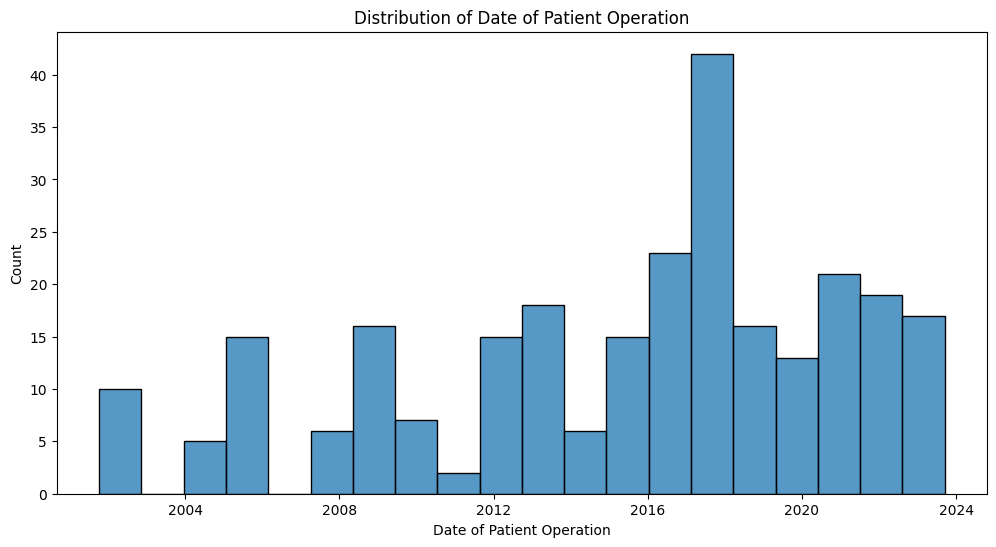

In [28]:
sns.histplot(df[column],bins=20)
plt.title(f"Distribution of Date of Patient Operation")
plt.xlabel('Date of Patient Operation')
plt.show()

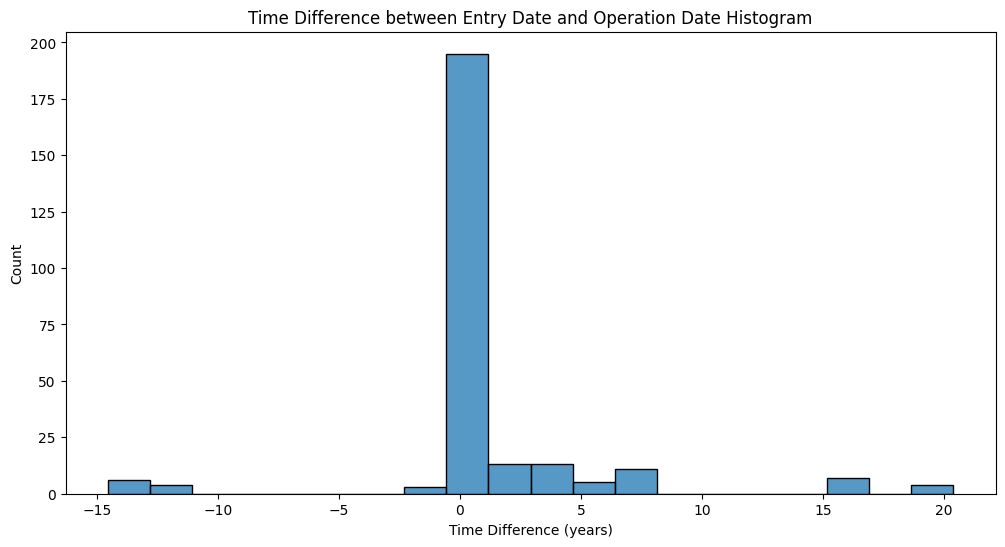

In [29]:
# calculate time difference in years between operation and entry date
df['EDDate_OPDate_Difference'] = (df['Operation_date'] - df['Entry_date']).dt.days /365
# Create a histogram to visualize the time differences
sns.histplot(df['EDDate_OPDate_Difference'], bins=20)
plt.title("Time Difference between Entry Date and Operation Date Histogram")
plt.xlabel("Time Difference (years)")
plt.ylabel("Count")
plt.show()

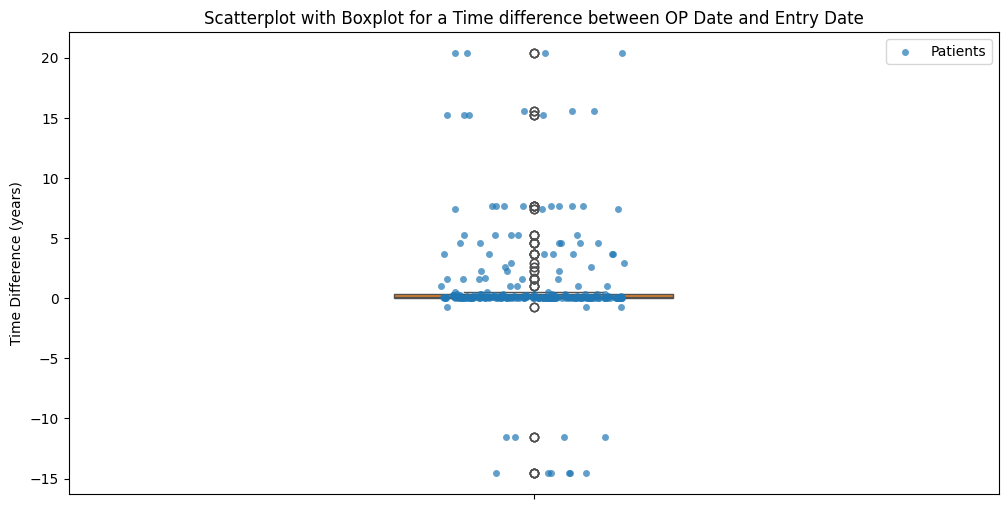

In [30]:
sns.stripplot(y=df['EDDate_OPDate_Difference'], jitter=True, legend=False,alpha=0.7,label="Patients")
sns.boxplot(y=df['EDDate_OPDate_Difference'], width=0.3)
plt.title("Scatterplot with Boxplot for a Time difference between OP Date and Entry Date")
plt.ylabel("Time Difference (years)")
plt.show()

#### Patient Age
The Patients age is also the data set. It might be needed to impute certain missing values of hormone levels.


In [31]:
column = 'Patient_age'
print("Range of ages:", df[column].min(), "to", df[column].max())
print("Mean Patient Age:", df[column].mean())
print("Median Patient Age:", df[column].median())
print("Missing values:", sum(df[column].isna()))

Range of ages: 17 to 86
Mean Patient Age: 57.37905236907731
Median Patient Age: 59.0
Missing values: 0


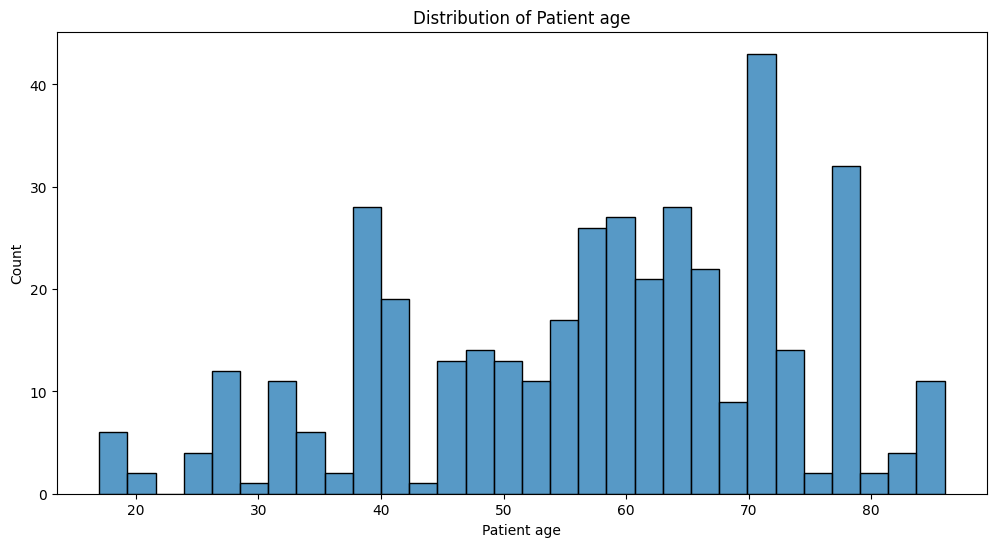

In [32]:
sns.histplot(df[column],bins=30)
plt.title(f"Distribution of Patient age")
plt.xlabel('Patient age')
plt.show()

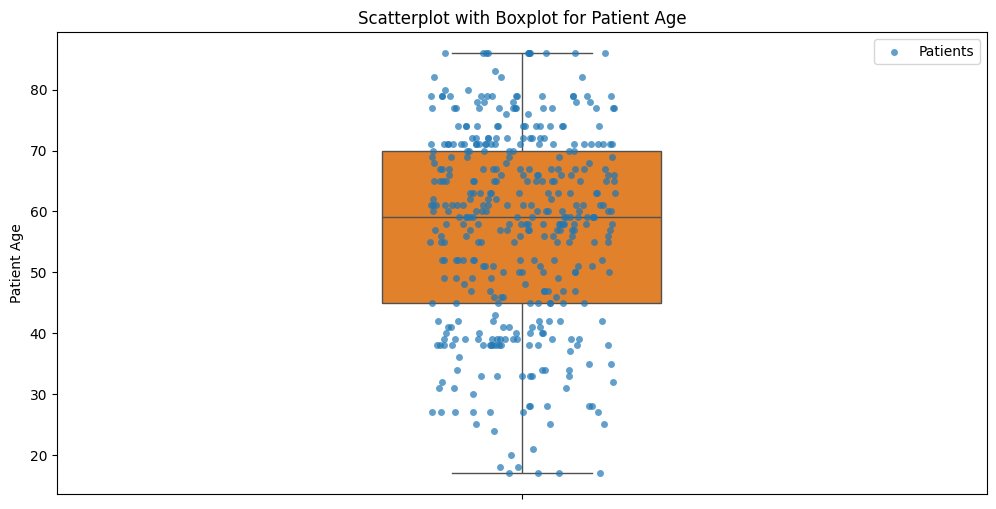

In [33]:
sns.stripplot(y=df[column], jitter=True, legend=False,alpha=0.7,label="Patients")
sns.boxplot(y=df[column], width=0.3)
plt.title("Scatterplot with Boxplot for Patient Age")
plt.ylabel("Patient Age")
plt.legend()
plt.show()

### Data Additional Laboratory Data (hormonal data)

Some Patients are missing lab values because they were transferred from external facilities like Kantonsspital Baden (KSB).
If the data was found by the labelers, we can include it in the models.

#### Prolactin (hormone)
The Column 'Prolactin' contains the measured values of prolactin for the patient.


In [34]:
column = 'Prolactin'
print("Range of Prolactin:", df[column].min(), "to", df[column].max())
print("Mean Prolactin:", df[column].mean())
print("Median Prolactin:", df[column].median())
print("Missing values:", sum(df[column].isna()))

Range of Prolactin: 50.0 to 74.0
Mean Prolactin: 63.61538461538461
Median Prolactin: 64.0
Missing values: 349


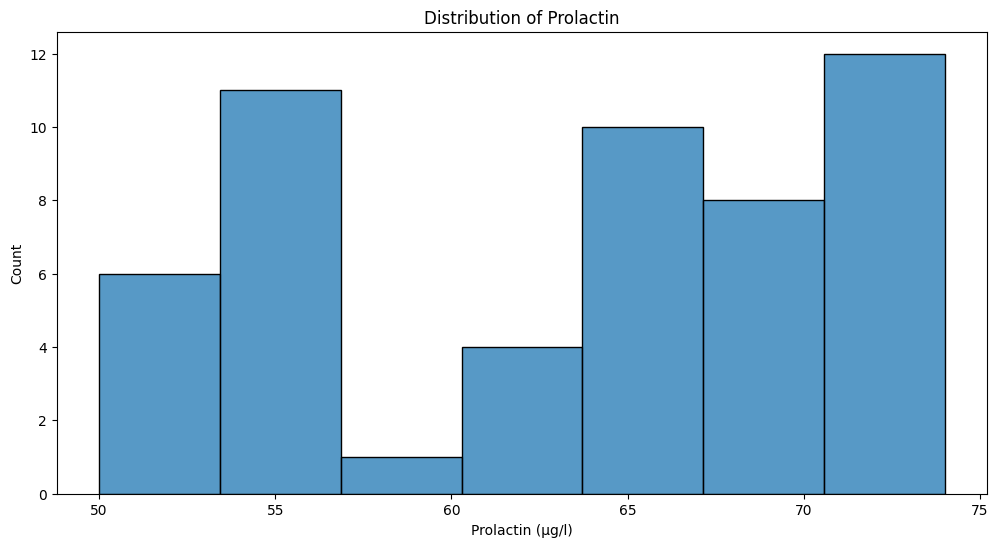

In [35]:
sns.histplot(df[column])
plt.title(f"Distribution of {column}")
plt.xlabel('Prolactin (μg/l)')
plt.show()

#### TSH (hormone)
The Column 'TSH' contains the measured values of thyroid stimulating
hormone for the patient.


In [36]:
column = 'TSH'
print("Range of TSH:", df[column].min(), "to", df[column].max())
print("Mean TSH:", df[column].mean())
print("Median TSH:", df[column].median())
print("Missing values:", sum(df[column].isna()))

Range of TSH: 30.0 to 47.0
Mean TSH: 38.5625
Median TSH: 36.0
Missing values: 369


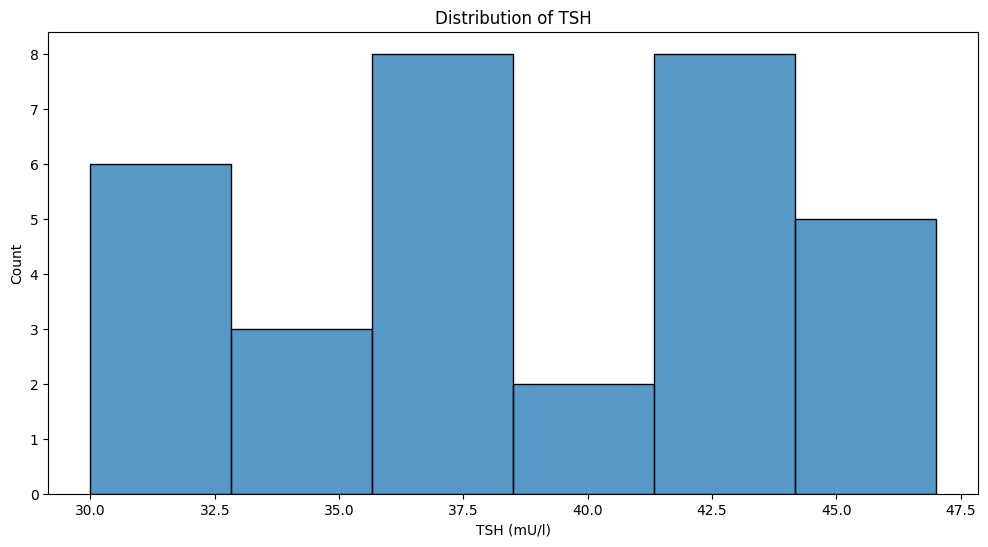

In [37]:
sns.histplot(df[column])
plt.title(f"Distribution of {column}")
plt.xlabel('TSH (mU/l)')
plt.show()

#### IGF1 (hormone)
The Column 'IGF1' contains the measured values of Insulin-like growth factor 1 for the patient.


In [38]:
column = 'IGF1'
print("Range of IGF1:", df[column].min(), "to", df[column].max())
print("Mean IGF1:", df[column].mean())
print("Median IGF1:", df[column].median())
print("Missing values:", sum(df[column].isna()))

Range of IGF1: 90.0 to 11444.0
Mean IGF1: 5857.111111111111
Median IGF1: 4956.0
Missing values: 374


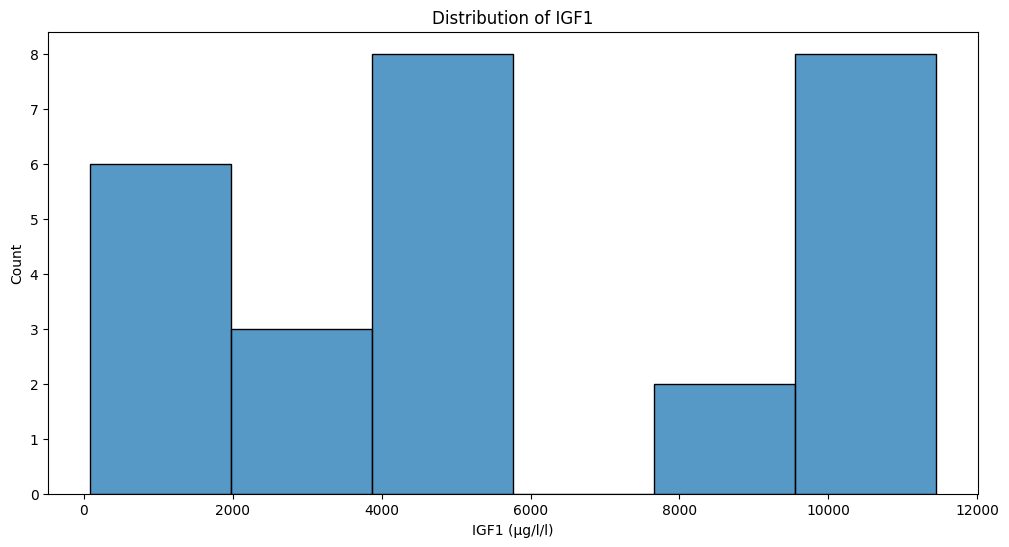

In [39]:
sns.histplot(df[column])
plt.title(f"Distribution of {column}")
plt.xlabel('IGF1 (μg/l/l)')
plt.show()

In [40]:
#TODO: add additional lab values if they are genereated

### Data Labels (Medical diagnosis data)

#### Category Prolactinoma (binary Label)
The Column 'Category' contains the actual label data if a adenoma is a prolactinoma or a non-prolactinoma.


In [41]:
column= 'Category'
print("Summary Statistics:\n",df[column].describe())
print("Percentage Distribution:\n",df[column].value_counts(normalize=True) * 100)
print("Missing values Adenoma category:", sum(df[column].isna()))

Summary Statistics:
 count                 401
unique                  2
top       non-prolaktinom
freq                  346
Name: Category, dtype: object
Percentage Distribution:
 Category
non-prolaktinom    86.284289
prolaktinom        13.715711
Name: proportion, dtype: float64
Missing values Adenoma category: 0


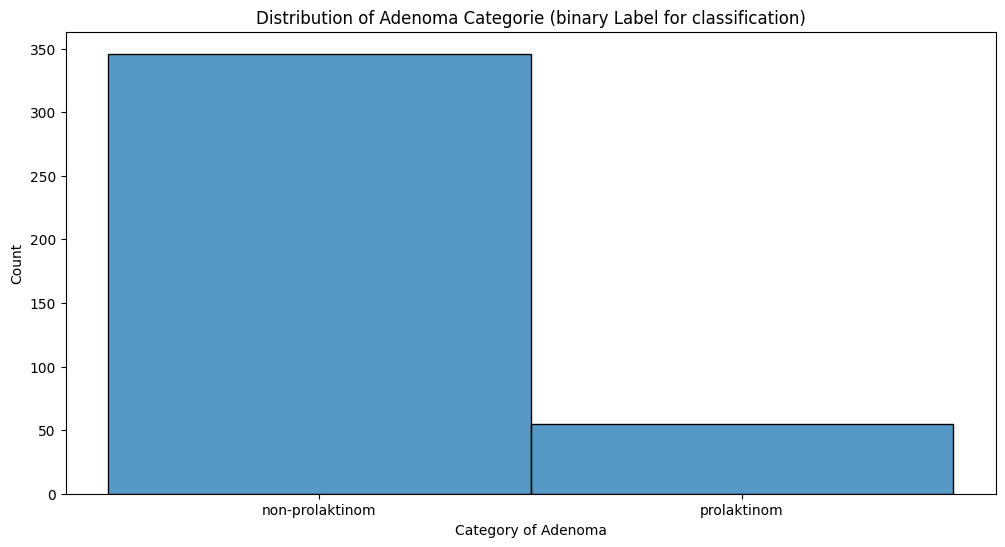

In [42]:
sns.histplot(df[column])
plt.title(f"Distribution of Adenoma Categorie (binary Label for classification)")
plt.xlabel('Category of Adenoma')
plt.show()

#### Diagnosis Prolactinoma (adenoma description)
The Column 'Diagnosis' contains the actual label data if a adenoma is a prolactinoma or a non-prolactinoma.


In [43]:
column= 'Diagnosis'
print("Summary Statistics:\n",df[column].describe())
print("Percentage Distribution:\n",df[column].value_counts(normalize=True) * 100)
print("Missing values Diagnosis:", sum(df[column].isna()))


Summary Statistics:
 count                  401
unique                   9
top       inaktiv (gonado)
freq                   138
Name: Diagnosis, dtype: object
Percentage Distribution:
 Diagnosis
inaktiv (gonado)    34.413965
inaktiv             31.920200
prolaktinom         13.715711
gh                   7.980050
rathke               6.733167
inaktiv (acth)       1.995012
normal               1.246883
acth                 0.997506
empty sella          0.997506
Name: proportion, dtype: float64
Missing values Diagnosis: 0


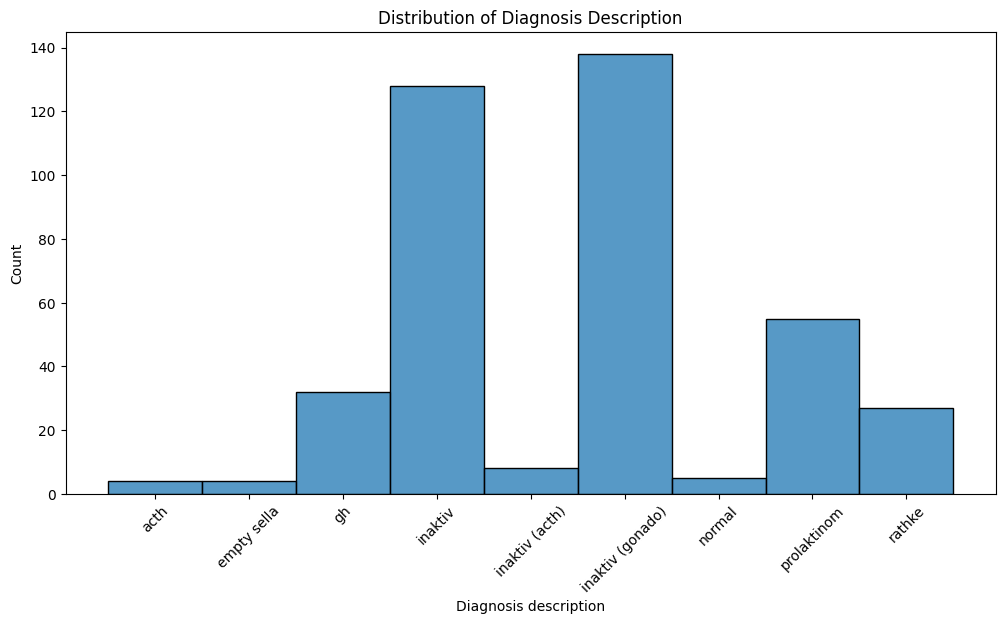

In [44]:
sns.histplot(df[column])
plt.title(f"Distribution of Diagnosis Description")
plt.xticks(rotation=45)
plt.xlabel('Diagnosis description')
plt.show()

##

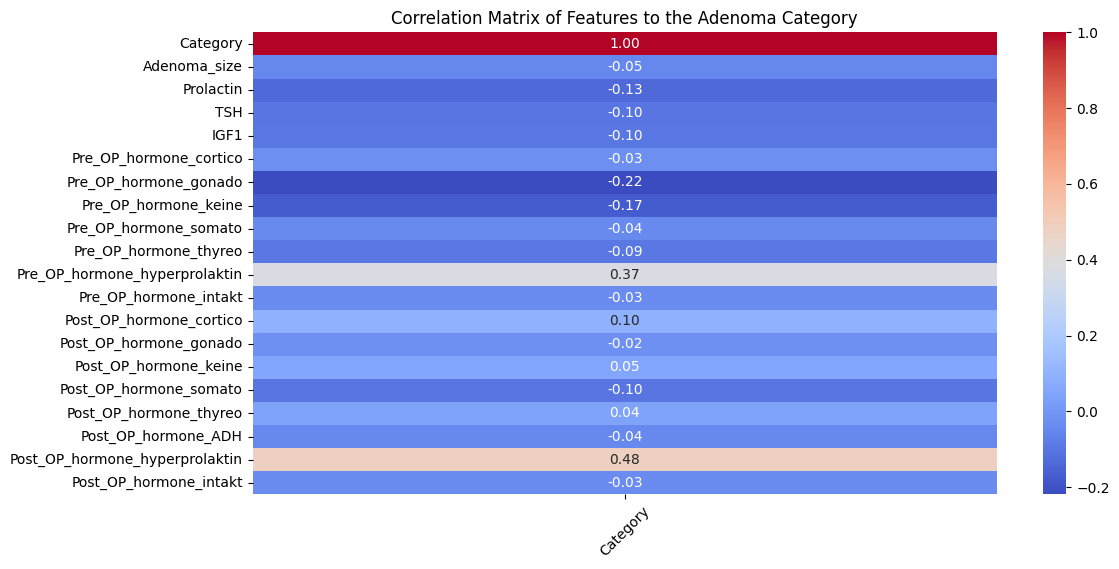

In [45]:
# factorise all features and then correlate them to each other
df_corr = df[['Category','Adenoma_size','Prolactin', 'TSH', 'IGF1']+pre_op_columns + post_op_columns].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
correlation_matrix = df_corr.iloc[:,0:1]

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features to the Adenoma Category")
plt.xticks(rotation=45)
plt.show()